In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
import pywt
from sklearn.decomposition import FastICA, PCA
from scipy.stats import pearsonr as pear
from scipy import signal

In [2]:
in_path_fg = "fits_files/"
in_path_cs = "Boxes/"

output_path = "Results/"
fname_all = "test_filename"

fname_foreground = "fg_all"
fname_cs = "test"


#1000 hours of noise
noise = fits.getdata(r'fits_files/noise_108.000MHz_210.300MHz_SKA_SKA_central_area_EOR0_0128_3.0_1000h_K.fits')
#100 hours
#noise = fits.getdata('fits_files/Noise_100.fits').T

indata_fg = fits.getdata(in_path_fg+fname_foreground+'.fits').T
indata_fg = indata_fg + noise

indata_cs = fits.getdata(in_path_cs+fname_cs+'.fits')
indata_cs = indata_cs/1000
sh = indata_cs.shape
print(sh)
print(indata_cs.shape)
no_sl = 342
#code for seperating by k-space
indata = indata_fg+indata_cs

(342, 128, 128)
(342, 128, 128)


In [3]:
# #############################################################################
# Generate sample data
#code for fastICA
all_cube_in = indata_fg+indata_cs

Dim = 128
nbrScale = 6

#observation
all_cube_in = (indata_fg+indata_cs).T
light = (indata_cs).T
print(np.shape(all_cube_in))


# Convert to sparse domain
WT = np.zeros((Dim,Dim,nbrScale)) # Desired array where we have squashed together the fine/approximation bits
WTc_approx = np.zeros((Dim,Dim,nbrScale))
WTc_fine = np.zeros((3,Dim,Dim,nbrScale))
# Convert to sparse domain
WT_l = np.zeros((Dim,Dim,nbrScale)) # Desired array where we have squashed together the fine/approximation bits
WTc_approx_l = np.zeros((Dim,Dim,nbrScale))
WTc_fine_l = np.zeros((3,Dim,Dim,nbrScale))

(128, 128, 342)


In [4]:
space = np.zeros((128,128,7,342))
space_light = np.zeros((128,128,7,342))
for i in range(no_sl):
    coeffs = pywt.swt2(all_cube_in[:,:,i],'Haar',nbrScale,norm='True')
    
    coeffs_light = pywt.swt2(light[:,:,i],'Haar',nbrScale,norm='True')

#Show the approximation and fine detail at each level
    for jj in range(0,nbrScale):
        WTc_approx[:,:,jj] = coeffs[jj][0]
        WTc_fine[:,:,:,jj] = coeffs[jj][1]
        space[:,:,0,i] = WTc_approx[:,:,0]
        # MERCILESSLY SQUASH THE ARRAYS
        WT[:,:,jj] = np.sum(WTc_fine[:,:,:,jj],axis=0)  # These are our wavelet coefficients
        
        WTc_approx_l[:,:,jj] = coeffs_light[jj][0]
        WTc_fine_l[:,:,:,jj] = coeffs_light[jj][1]
        space_light[:,:,0,i] = WTc_approx_l[:,:,0]
    
        # MERCILESSLY SQUASH THE ARRAYS
        WT_l[:,:,jj] = np.sum(WTc_fine_l[:,:,:,jj],axis=0)  # These are our wavelet coefficients
    

    space[:,:,1:7,i] = WT[:,:,0:6]
    
    space_light[:,:,1:7,i] = WT_l[:,:,0:6]

    #out = WTc_approx[:,:,0] + np.sum(WT[:,:,0:nbrScale],axis=2)

In [5]:
res = np.zeros((342,128,128,7))
rec = np.zeros((342,128,128,7))

for i in range(7):
    indata = space[:,:,i,:].T
    sh = indata.shape
    print(sh)
    X = np.reshape(indata,(sh[0], sh[1]*sh[2]))
     
    ncomp = 3
        
    ica1 = FastICA(n_components=ncomp)
    model1 = []
    S = ica1.fit_transform(X.T)  # Reconstruct signals
    A = ica1.mixing_  # Get estimated mixing matrix

    model1 = np.reshape(np.matmul(A,S.T),(sh[0], sh[1],sh[2]))
    res[:,:,:,i] = indata-model1

(342, 128, 128)
(342, 128, 128)


/Users/student2/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


(342, 128, 128)


/Users/student2/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


(342, 128, 128)
(342, 128, 128)
(342, 128, 128)
(342, 128, 128)


In [6]:
corr = np.zeros((7))
for i in range(7):
    first = res[:,:,:,i]
    second = space_light[:,:,i,:]
    corr[i] = pear(first.flatten(),second.flatten())[0]
print(corr)

[-5.80504646e-04 -7.40659377e-04  6.85177190e-05  5.79104320e-04
  7.02240344e-04  3.00846594e-04  2.12404975e-04]


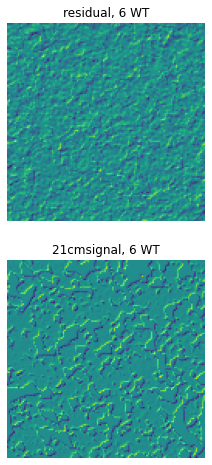

In [7]:

fig, axes = plt.subplots(2, 1, figsize=(6,8))

axes[0].imshow(res[100,:,:,6]) # no of slice and k-space, res
axes[0].set_title('residual, 6 WT')
axes[0].axis('off')

axes[1].imshow(space_light[:,:,6,100]) # k-space and no of slices, 21cm
axes[1].set_title('21cmsignal, 6 WT')
axes[1].axis('off')

plt.savefig('images/The sixth WT of the residual and 21cmsignal')